# What this file does

Examines the relative contribution of various the four main SVI themes — socioeconomic status, household composition & disability, minority status & language, housing type and transportation — to vaccination rates. 

Background reading: https://www.cdc.gov/mmwr/volumes/70/wr/mm7012e1.htm?s_cid=mm7012e1_w#contribAff "State and local jurisdictions should also consider analyzing SVI metrics at the level of the census tract."
Main findings: 
        1) Socioeconomic factors have strongest effect on vaccine uptake 
        2) Education was associated with the greatest disparity  
        
My findings are consistent with this, though my methodology differs slightly. Don't think I cant really go this far with the analysis. 

Steps:
- Join SVI with vaxx rate
- Run correlations with overall SVI, themes
- Run regression with four themes separately
- Run multivariate regression with all four 

# Tools

In [1]:
#analysis tools
import pandas as pd
import plotly.express as px
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

#regression tools
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.sandbox.regression.predstd import wls_prediction_std

# Read in data

In [2]:
#read in SVI data 
df_ct_svi = pd.read_csv('Connecticut.csv')

In [3]:
#isolate SVI theme variables
df_ct_svi_themes = df_ct_svi[['FIPS','RPL_THEME1','RPL_THEME2','RPL_THEME3','RPL_THEME4','RPL_THEMES']]

In [46]:
#when
df_vax_ct['DateUpdate'].value_counts()

5/26/2021    831
Name: DateUpdate, dtype: int64

In [7]:
#CT vaccination data 
#df_vax_ct = pd.read_csv('COVID-19_Vaccinations_by_Census_Tract (5).csv')
df_vax_ct = pd.read_csv('COVP Coverage by Census Tract_  Ages 16 and Up (5).csv')

In [8]:
#looks like we're missing a Census tract in the overall
len(df_ct_svi_themes),len(df_vax_ct)

(830, 831)

In [9]:
#prepped data after merge
df_final = df_vax_ct.merge(df_ct_svi_themes, left_on='GEOID10', right_on='FIPS')
len(df_final)

830

In [10]:
#removing values for which the overall SVI index is suppressed
df_final_svi_not_suppressed = df_final[df_final['RPL_THEMES']!=-999]
len(df_final_svi_not_suppressed)

827

# Descriptive statistics 

In [13]:
df_vax_ct.columns

Index(['OBJECTID', 'GEOID10', 'CTTractID', 'DateUpdate', 'TractTown',
       'Cov_16Plus', 'Cov_16_44', 'Cov_45_64', 'Cov_65Plus', 'needvac_16_plus',
       'needvac_16_44', 'needvac_45_64', 'needvac_65_plus'],
      dtype='object')

In [14]:
#50% of Census tracts under the statewide coverage rate
# df_vax_ct['Sixteen_plus'].hist()
# df_vax_ct['Sixteen_plus'].median()

df_vax_ct['Cov_16Plus'].hist()
df_vax_ct['Cov_16Plus'].median()

65.98694943

86.4142539

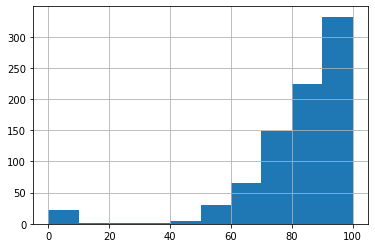

In [15]:
#much higher covg overall with just 65+
df_vax_ct['Cov_65Plus'].hist()
df_vax_ct['Cov_65Plus'].median()

<AxesSubplot:>

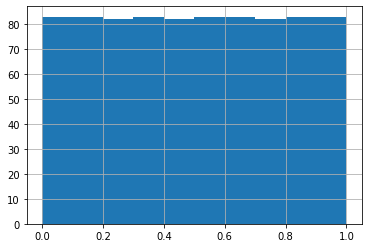

In [16]:
#SVI index value distribution
df_final_svi_not_suppressed['RPL_THEMES'].hist()

In [17]:
#socioeconomic factors
df_final_svi_not_suppressed['RPL_THEME1'].hist()
df_final_svi_not_suppressed['RPL_THEME1'].median()

0.5

0.4994

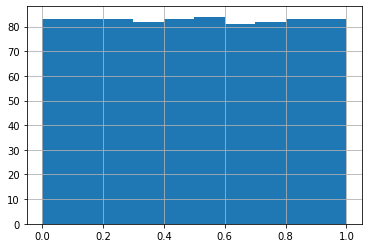

In [18]:
#minority and english language ability 
df_final_svi_not_suppressed['RPL_THEME3'].hist()
df_final_svi_not_suppressed['RPL_THEME3'].median()

# Correlation analyses

1. Overall SVI

In [19]:
#strong -ve correlation with overall; more vulnerable, lower vaxx rate
# df_final_svi_not_suppressed[df_final_svi_not_suppressed['RPL_THEMES']!=-999][['Sixteen_plus','RPL_THEMES']].corr()
df_final_svi_not_suppressed[df_final_svi_not_suppressed['RPL_THEMES']!=-999][['Cov_16Plus','RPL_THEMES']].corr()

Cov_16Plus  RPL_THEMES
Cov_16Plus    1.000000   -0.598524
RPL_THEMES   -0.598524    1.000000

In [20]:
#plot to confirm
fig = px.scatter(df_final_svi_not_suppressed, x="RPL_THEMES", y="Cov_16Plus")
fig.show()

a) Socioeconomic indicators

In [21]:
#factoring out suppressed values; not many suppressed, so we're good
df_final_svi_not_suppressed_1 = df_final[df_final['RPL_THEME1']!=-999]
len(df_final_svi_not_suppressed_1)

827

In [22]:
#higher -ve correlation
#df_final_svi_not_suppressed_1[['Sixteen_plus','RPL_THEME1']].corr()
#Cov_16Plus
df_final_svi_not_suppressed_1[['Cov_16Plus','RPL_THEME1']].corr()


Cov_16Plus  RPL_THEME1
Cov_16Plus    1.000000   -0.705686
RPL_THEME1   -0.705686    1.000000

In [23]:
#plot to confirm; tighter tail
fig = px.scatter(df_final_svi_not_suppressed_1, x="RPL_THEME1", y="Cov_16Plus")
fig.show()

b) Household and Disability

In [24]:
#removing suppressed values
df_final_svi_not_suppressed_2 = df_final[df_final['RPL_THEME2']!=-999]
len(df_final_svi_not_suppressed_2)

827

In [25]:
#weak negative
df_final_svi_not_suppressed_2[['Cov_16Plus','RPL_THEME2']].corr()

Cov_16Plus  RPL_THEME2
Cov_16Plus    1.000000   -0.298382
RPL_THEME2   -0.298382    1.000000

c) Minority status and language

In [26]:
#removing suppressed values
df_final_svi_not_suppressed_3 = df_final[df_final['RPL_THEME3']!=-999]
len(df_final_svi_not_suppressed_3)

828

In [27]:
#again, negative
df_final_svi_not_suppressed_3[['Cov_16Plus','RPL_THEME3']].corr()

Cov_16Plus  RPL_THEME3
Cov_16Plus    1.000000   -0.464895
RPL_THEME3   -0.464895    1.000000

In [28]:
#plot to confirm; tighter tail
fig = px.scatter(df_final_svi_not_suppressed_3, x="RPL_THEME3", y="Cov_16Plus")
fig.show()

d) Housing situation and transportation

In [29]:
#remove suppressed
df_final_svi_not_suppressed_4 = df_final[df_final['RPL_THEME4']!=-999]
len(df_final_svi_not_suppressed_4)

827

In [30]:
#weak negative
df_final_svi_not_suppressed_4[['Cov_16Plus','RPL_THEME4']].corr()

Cov_16Plus  RPL_THEME4
Cov_16Plus    1.000000   -0.425789
RPL_THEME4   -0.425789    1.000000

# Variable isolation for regression analysis

In [31]:
#overall vaccination rate, SVI themes, overall SVI
#df_final_final = df_final[['Sixteen_plus','RPL_THEMES','RPL_THEME1','RPL_THEME2','RPL_THEME3','RPL_THEME4']]
df_final_final = df_final[['Cov_16Plus','RPL_THEMES','RPL_THEME1','RPL_THEME2','RPL_THEME3','RPL_THEME4']]

In [32]:
#checking that all datatypes are numbers
df_final_final.dtypes

Cov_16Plus    float64
RPL_THEMES    float64
RPL_THEME1    float64
RPL_THEME2    float64
RPL_THEME3    float64
RPL_THEME4    float64
dtype: object

In [33]:
#removing all suppressed values
df_final_for_regression = df_final_final[~df_final_final.eq(-999).any(1)]
len(df_final_for_regression)

827

In [48]:
df_final_for_regression.to_clipboard()

In [35]:
#looking at theme 3 and theme 1
df_final_for_regression[['Cov_16Plus','RPL_THEME3', 'RPL_THEME1']].corr()

Cov_16Plus  RPL_THEME3  RPL_THEME1
Cov_16Plus    1.000000   -0.464355   -0.705686
RPL_THEME3   -0.464355    1.000000    0.740349
RPL_THEME1   -0.705686    0.740349    1.000000

# Regression coefficients

In [36]:
#quick look at coeeficients
regression_model = LinearRegression()
training_data = df_final_for_regression[['RPL_THEME1','RPL_THEME2','RPL_THEME3','RPL_THEME4']]
target_values = df_final_for_regression["Cov_16Plus"]
regression_model.fit(training_data, target_values)
estimates = regression_model.coef_
print(estimates)

[-44.57808844   3.83435884   7.03035487   0.39472198]


In [37]:
#overall
regression_model = LinearRegression()
training_data = df_final_for_regression[['RPL_THEMES']]
target_values = df_final_for_regression["Cov_16Plus"]
regression_model.fit(training_data, target_values)
estimates = regression_model.coef_
print(estimates)

[-31.57712397]


In [38]:
#Socioeconomic alone
regression_model = LinearRegression()
training_data = df_final_for_regression[['RPL_THEME1']]
target_values = df_final_for_regression["Cov_16Plus"]
regression_model.fit(training_data, target_values)
estimates = regression_model.coef_
print(estimates)

[-37.2306182]


In [39]:
#Household composition and disability 
regression_model = LinearRegression()
training_data = df_final_for_regression[['RPL_THEME2']]
target_values = df_final_for_regression["Cov_16Plus"]
regression_model.fit(training_data, target_values)
estimates = regression_model.coef_
print(estimates)

[-15.7425461]


In [40]:
#Minority status and language
regression_model = LinearRegression()
training_data = df_final_for_regression[['RPL_THEME3']]
target_values = df_final_for_regression["Cov_16Plus"]
regression_model.fit(training_data, target_values)
estimates = regression_model.coef_
print(estimates)

[-24.49159313]


In [41]:
#Housing type and transportation
regression_model = LinearRegression()
training_data = df_final_for_regression[['RPL_THEME4']]
target_values = df_final_for_regression["Cov_16Plus"]
regression_model.fit(training_data, target_values)
estimates = regression_model.coef_
print(estimates)

[-22.46239408]


# Regression summary

In [42]:
#Sixteen plus with overall SVI 
vaccination_model = ols("""Cov_16Plus ~ RPL_THEMES""", data=df_final_for_regression).fit()
# summarize our model
vaccination_model.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             Cov_16Plus   R-squared:                       0.358
Model:                            OLS   Adj. R-squared:                  0.357
Method:                 Least Squares   F-statistic:                     460.5
Date:                Wed, 02 Jun 2021   Prob (F-statistic):           1.62e-81
Time:                        13:46:14   Log-Likelihood:                -3243.2
No. Observations:                 827   AIC:                             6490.
Df Residuals:                     825   BIC:                             6500.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     80.5096      0.850     94.739      0.000      78.842      82.178
RPL_THEMES   -31.5771      1.471    -21.459      0.000     -34.465     -28.689
==============================================================================
Omnibus:                      252.561   Durbin-Watson:                   1.380
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1568.565
Skew:                          -1.234   Prob(JB):                         0.00
Kurtosis:                       9.279   Cond. No.                         4.39
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [43]:
#Sixteen plus with the themes
vaccination_model = ols("""Cov_16Plus ~ RPL_THEME1
                                            + RPL_THEME2
                                            + RPL_THEME3
                                            + RPL_THEME4""", data=df_final_for_regression).fit()
# summarize our model
vaccination_model.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             Cov_16Plus   R-squared:                       0.510
Model:                            OLS   Adj. R-squared:                  0.507
Method:                 Least Squares   F-statistic:                     213.5
Date:                Wed, 02 Jun 2021   Prob (F-statistic):          1.49e-125
Time:                        13:46:17   Log-Likelihood:                -3132.1
No. Observations:                 827   AIC:                             6274.
Df Residuals:                     822   BIC:                             6298.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     81.3825      0.911     89.320      0.000      79.594      83.171
RPL_THEME1   -44.5781      2.220    -20.080      0.000     -48.936     -40.221
RPL_THEME2     3.8344      1.487      2.579      0.010       0.916       6.753
RPL_THEME3     7.0304      1.959      3.589      0.000       3.185      10.876
RPL_THEME4     0.3947      1.695      0.233      0.816      -2.932       3.722
==============================================================================
Omnibus:                      287.175   Durbin-Watson:                   1.434
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2523.478
Skew:                          -1.318   Prob(JB):                         0.00
Kurtosis:                      11.142   Cond. No.                         10.6
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Questions:

    1) Can I say that socioeconomic factors are the strongest predictor of vaccination rate within factors considered by the SVI? 
    2) Can I say that when socioeconomic factors are controlled for, tracts with more minorities are associated with higher vaccine uptake? 
    3) Can I do a further analysis with the socioeconomic indicators? 


# Effect modification

In [108]:
#Sixteen plus with the themes
vaccination_model = ols("""Sixteen_plus ~ RPL_THEME1
                                            + RPL_THEME2
                                            + RPL_THEME3
                                            + RPL_THEME4""", data=df_final_for_regression[df_final_for_regression['RPL_THEME1']>0.5]).fit()
# summarize our model
vaccination_model.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           Sixteen_plus   R-squared:                       0.383
Model:                            OLS   Adj. R-squared:                  0.377
Method:                 Least Squares   F-statistic:                     63.25
Date:                Tue, 25 May 2021   Prob (F-statistic):           1.42e-41
Time:                        13:07:15   Log-Likelihood:                -1554.9
No. Observations:                 413   AIC:                             3120.
Df Residuals:                     408   BIC:                             3140.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     95.3612      2.833     33.658      0.000      89.792     100.931
RPL_THEME1   -74.4783      5.696    -13.076      0.000     -85.675     -63.281
RPL_THEME2     5.9810      2.055      2.911      0.004       1.942      10.020
RPL_THEME3    10.0209      2.851      3.515      0.000       4.417      15.625
RPL_THEME4     3.0670      2.412      1.271      0.204      -1.675       7.809
==============================================================================
Omnibus:                       78.961   Durbin-Watson:                   1.914
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              522.618
Skew:                          -0.609   Prob(JB):                    3.27e-114
Kurtosis:                       8.375   Cond. No.                         21.2
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [109]:
#Sixteen plus with the themes
vaccination_model = ols("""Sixteen_plus ~ RPL_THEME1
                                            + RPL_THEME2
                                            + RPL_THEME3
                                            + RPL_THEME4""", data=df_final_for_regression[df_final_for_regression['RPL_THEME1']<0.5]).fit()
# summarize our model
vaccination_model.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           Sixteen_plus   R-squared:                       0.221
Model:                            OLS   Adj. R-squared:                  0.213
Method:                 Least Squares   F-statistic:                     28.90
Date:                Tue, 25 May 2021   Prob (F-statistic):           3.63e-21
Time:                        13:07:19   Log-Likelihood:                -1523.2
No. Observations:                 413   AIC:                             3056.
Df Residuals:                     408   BIC:                             3076.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     75.6316      1.327     56.976      0.000      73.022      78.241
RPL_THEME1   -36.7823      3.694     -9.957      0.000     -44.044     -29.521
RPL_THEME2     6.7094      2.062      3.254      0.001       2.656      10.763
RPL_THEME3     8.5137      2.670      3.188      0.002       3.264      13.763
RPL_THEME4    -1.8146      2.153     -0.843      0.400      -6.047       2.418
==============================================================================
Omnibus:                      233.315   Durbin-Watson:                   1.595
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3479.822
Skew:                          -2.068   Prob(JB):                         0.00
Kurtosis:                      16.605   Cond. No.                         9.70
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [101]:
#Sixteen plus with the themes
vaccination_model = ols("""Sixteen_plus ~ RPL_THEME1
                                            + RPL_THEME2
                                            + RPL_THEME3
                                            + RPL_THEME4""", data=df_final_for_regression[df_final_for_regression['RPL_THEME3']>0.49]).fit()
# summarize our model
vaccination_model.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           Sixteen_plus   R-squared:                       0.530
Model:                            OLS   Adj. R-squared:                  0.525
Method:                 Least Squares   F-statistic:                     117.1
Date:                Tue, 25 May 2021   Prob (F-statistic):           8.27e-67
Time:                        06:13:38   Log-Likelihood:                -1577.0
No. Observations:                 421   AIC:                             3164.
Df Residuals:                     416   BIC:                             3184.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     91.1832      2.702     33.747      0.000      85.872      96.495
RPL_THEME1   -42.4294      3.651    -11.620      0.000     -49.607     -35.252
RPL_THEME2     0.4686      1.954      0.240      0.811      -3.373       4.310
RPL_THEME3   -13.9189      5.162     -2.697      0.007     -24.065      -3.773
RPL_THEME4     4.7185      2.341      2.015      0.044       0.117       9.321
==============================================================================
Omnibus:                       84.411   Durbin-Watson:                   1.735
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              602.551
Skew:                          -0.630   Prob(JB):                    1.44e-131
Kurtosis:                       8.724   Cond. No.                         20.6
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [102]:
#Sixteen plus with the themes
vaccination_model = ols("""Sixteen_plus ~ RPL_THEME1
                                            + RPL_THEME2
                                            + RPL_THEME3
                                            + RPL_THEME4""", data=df_final_for_regression[df_final_for_regression['RPL_THEME3']<0.49]).fit()
# summarize our model
vaccination_model.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           Sixteen_plus   R-squared:                       0.416
Model:                            OLS   Adj. R-squared:                  0.410
Method:                 Least Squares   F-statistic:                     71.43
Date:                Tue, 25 May 2021   Prob (F-statistic):           1.21e-45
Time:                        06:13:46   Log-Likelihood:                -1508.2
No. Observations:                 406   AIC:                             3026.
Df Residuals:                     401   BIC:                             3046.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     75.1372      1.348     55.728      0.000      72.487      77.788
RPL_THEME1   -40.1335      2.817    -14.246      0.000     -45.672     -34.595
RPL_THEME2     9.4401      2.117      4.459      0.000       5.278      13.602
RPL_THEME3    13.4421      3.568      3.767      0.000       6.428      20.456
RPL_THEME4    -4.8846      2.253     -2.168      0.031      -9.314      -0.456
==============================================================================
Omnibus:                      193.984   Durbin-Watson:                   1.793
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1994.632
Skew:                          -1.767   Prob(JB):                         0.00
Kurtosis:                      13.268   Cond. No.                         9.03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""